In [0]:
import os
import shutil
import zipfile
import keras
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.preprocessing import image
import cv2

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [0]:
if not os.path.isdir('/tmp/TL-Inceptionv3/'):
  os.mkdir('/tmp/TL-Inceptionv3/')

In [32]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/TL-Inceptionv3/cats_and_dogs_filtered.zip
  

local_zip = '/tmp/TL-Inceptionv3/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/TL-Inceptionv3/')
zip_ref.close()

--2019-07-15 13:02:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/TL-Inceptionv3/cats_and_dogs_filtered.zip’

/tmp/TL-Inceptionv3 100%[===================>]  65.43M  77.1MB/s    in 0.8s    

2019-07-15 13:02:12 (77.1 MB/s) - ‘/tmp/TL-Inceptionv3/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
base_dir = '/tmp/TL-Inceptionv3/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')                 

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)

predictions = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# We freeze the all layers from the InceptionV3 model, so that we only train the newly added
# We can also try to freeze only few of the first layers of the InceptionV3 model to see if this will give us better results
for layer in base_model.layers[0:250]:
    layer.trainable = False

In [36]:
print(len(base_model.layers))

311


In [38]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

target_width = 300
target_height = 300

train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=40,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2,
      callbacks=[es])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/40
 - 88s - loss: 0.1223 - acc: 0.9655 - val_loss: 0.0356 - val_acc: 0.9850
Epoch 2/40
 - 59s - loss: 0.0943 - acc: 0.9705 - val_loss: 0.0253 - val_acc: 0.9900
Epoch 3/40
 - 62s - loss: 0.0679 - acc: 0.9735 - val_loss: 3.0179e-05 - val_acc: 1.0000
Epoch 4/40
 - 62s - loss: 0.0865 - acc: 0.9785 - val_loss: 0.0855 - val_acc: 0.9900
Epoch 5/40
 - 62s - loss: 0.0789 - acc: 0.9750 - val_loss: 0.0472 - val_acc: 0.9900
Epoch 6/40
 - 62s - loss: 0.0439 - acc: 0.9850 - val_loss: 0.0214 - val_acc: 0.9950
Epoch 7/40
 - 62s - loss: 0.0493 - acc: 0.9875 - val_loss: 4.2024e-04 - val_acc: 1.0000
Epoch 8/40
 - 62s - loss: 0.0315 - acc: 0.9885 - val_loss: 0.0170 - val_acc: 0.9900
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping


Freezing all layers:
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/40
 - 33s - loss: 0.6028 - acc: 0.7705 - val_loss: 0.0891 - val_acc: 0.9800
Epoch 2/40
 - 23s - loss: 0.2875 - acc: 0.8770 - val_loss: 0.0811 - val_acc: 0.9700
Epoch 3/40
 - 23s - loss: 0.2531 - acc: 0.8965 - val_loss: 0.0356 - val_acc: 1.0000
Epoch 4/40
 - 23s - loss: 0.2357 - acc: 0.9145 - val_loss: 0.0890 - val_acc: 0.9700
Epoch 5/40
 - 23s - loss: 0.1862 - acc: 0.9280 - val_loss: 0.1551 - val_acc: 0.9550
Epoch 6/40
 - 23s - loss: 0.1814 - acc: 0.9325 - val_loss: 0.0499 - val_acc: 0.9900
Epoch 7/40
 - 23s - loss: 0.1606 - acc: 0.9360 - val_loss: 0.0382 - val_acc: 0.9850
Epoch 8/40
 - 23s - loss: 0.1520 - acc: 0.9470 - val_loss: 0.0279 - val_acc: 0.9900
Epoch 9/40
 - 23s - loss: 0.1294 - acc: 0.9555 - val_loss: 0.1230 - val_acc: 0.9700
Epoch 10/40
 - 23s - loss: 0.1444 - acc: 0.9425 - val_loss: 0.0807 - val_acc: 0.9650
Epoch 11/40
 - 23s - loss: 0.1158 - acc: 0.9555 - val_loss: 0.0509 - val_acc: 0.9850
Epoch 12/40
 - 23s - loss: 0.1213 - acc: 0.9560 - val_loss: 0.0745 - val_acc: 0.9700
Epoch 13/40
 - 23s - loss: 0.0915 - acc: 0.9625 - val_loss: 0.0307 - val_acc: 0.9900
Restoring model weights from the end of the best epoch
Epoch 00013: early stopping


Freezing first 20 layers:
Epoch 1/40
 - 89s - loss: 0.1840 - acc: 0.9370 - val_loss: 0.0630 - val_acc: 0.9750
Epoch 2/40
 - 66s - loss: 0.0603 - acc: 0.9845 - val_loss: 0.1380 - val_acc: 0.9650
Epoch 3/40
 - 66s - loss: 0.0546 - acc: 0.9880 - val_loss: 0.1318 - val_acc: 0.9800
Epoch 4/40
 - 66s - loss: 0.0588 - acc: 0.9920 - val_loss: 0.0822 - val_acc: 0.9850
Epoch 5/40
 - 66s - loss: 0.0160 - acc: 0.9945 - val_loss: 0.0882 - val_acc: 0.9900
Epoch 6/40
 - 66s - loss: 0.0221 - acc: 0.9960 - val_loss: 0.2211 - val_acc: 0.9750
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping

Freezing first 150 layers:
Epoch 1/40
 - 65s - loss: 0.2067 - acc: 0.9340 - val_loss: 0.0219 - val_acc: 0.9900
Epoch 2/40
 - 43s - loss: 0.0515 - acc: 0.9815 - val_loss: 0.0630 - val_acc: 0.9850
Epoch 3/40
 - 43s - loss: 0.0318 - acc: 0.9890 - val_loss: 0.0910 - val_acc: 0.9850
Epoch 4/40
 - 43s - loss: 0.0268 - acc: 0.9935 - val_loss: 0.0569 - val_acc: 0.9850
Epoch 5/40
 - 43s - loss: 0.0119 - acc: 0.9950 - val_loss: 0.0377 - val_acc: 0.9900
Epoch 6/40
 - 43s - loss: 0.0150 - acc: 0.9970 - val_loss: 0.0356 - val_acc: 0.9950
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping

Freezing firts 250 layers:
Epoch 1/40
 - 51s - loss: 0.2320 - acc: 0.9410 - val_loss: 0.0281 - val_acc: 0.9900
Epoch 2/40
 - 30s - loss: 0.0866 - acc: 0.9745 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 3/40
 - 30s - loss: 0.0596 - acc: 0.9815 - val_loss: 0.0458 - val_acc: 0.9850
Epoch 4/40
 - 30s - loss: 0.0328 - acc: 0.9925 - val_loss: 0.0349 - val_acc: 0.9950
Epoch 5/40
 - 30s - loss: 0.0157 - acc: 0.9940 - val_loss: 7.0366e-04 - val_acc: 1.0000
Epoch 6/40
 - 30s - loss: 0.0270 - acc: 0.9940 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 7/40
 - 30s - loss: 0.0063 - acc: 0.9975 - val_loss: 0.0399 - val_acc: 0.9900
Epoch 8/40
 - 30s - loss: 0.0040 - acc: 0.9985 - val_loss: 0.1168 - val_acc: 0.9800
Epoch 9/40
 - 30s - loss: 0.0116 - acc: 0.9975 - val_loss: 0.0191 - val_acc: 0.9950
Epoch 10/40
 - 30s - loss: 0.0015 - acc: 0.9990 - val_loss: 0.0568 - val_acc: 0.9900
Restoring model weights from the end of the best epoch
Epoch 00010: early stopping

Freezing first 250 layers and 3 dense layers:
Epoch 1/40
 - 56s - loss: 0.1736 - acc: 0.9345 - val_loss: 0.0196 - val_acc: 0.9900
Epoch 2/40
 - 32s - loss: 0.0597 - acc: 0.9805 - val_loss: 0.0172 - val_acc: 0.9950
Epoch 3/40
 - 32s - loss: 0.0249 - acc: 0.9920 - val_loss: 0.0698 - val_acc: 0.9900
Epoch 4/40
 - 32s - loss: 0.0101 - acc: 0.9965 - val_loss: 3.1415e-04 - val_acc: 1.0000
Epoch 5/40
 - 32s - loss: 0.0336 - acc: 0.9940 - val_loss: 0.0335 - val_acc: 0.9900
Epoch 6/40
 - 32s - loss: 0.0211 - acc: 0.9945 - val_loss: 0.0897 - val_acc: 0.9800
Epoch 7/40
 - 32s - loss: 0.0039 - acc: 0.9985 - val_loss: 0.0385 - val_acc: 0.9950
Epoch 8/40
 - 32s - loss: 0.0113 - acc: 0.9980 - val_loss: 9.3989e-04 - val_acc: 1.0000
Epoch 9/40
 - 32s - loss: 0.0088 - acc: 0.9990 - val_loss: 0.0631 - val_acc: 0.9900
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping

Freezing first 250 layers and 3 dense layers + image augmentation
Epoch 1/40
 - 88s - loss: 0.1223 - acc: 0.9655 - val_loss: 0.0356 - val_acc: 0.9850
Epoch 2/40
 - 59s - loss: 0.0943 - acc: 0.9705 - val_loss: 0.0253 - val_acc: 0.9900
Epoch 3/40
 - 62s - loss: 0.0679 - acc: 0.9735 - val_loss: 3.0179e-05 - val_acc: 1.0000
Epoch 4/40
 - 62s - loss: 0.0865 - acc: 0.9785 - val_loss: 0.0855 - val_acc: 0.9900
Epoch 5/40
 - 62s - loss: 0.0789 - acc: 0.9750 - val_loss: 0.0472 - val_acc: 0.9900
Epoch 6/40
 - 62s - loss: 0.0439 - acc: 0.9850 - val_loss: 0.0214 - val_acc: 0.9950
Epoch 7/40
 - 62s - loss: 0.0493 - acc: 0.9875 - val_loss: 4.2024e-04 - val_acc: 1.0000
Epoch 8/40
 - 62s - loss: 0.0315 - acc: 0.9885 - val_loss: 0.0170 - val_acc: 0.9900
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping

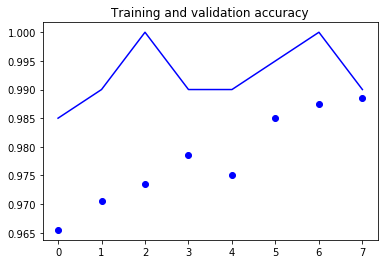

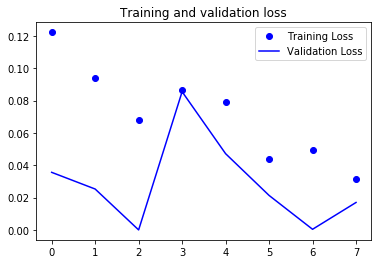

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
if not os.path.isdir('/tmp/TL-Inceptionv3/heatmaps'):
  os.mkdir('/tmp/TL-Inceptionv3/heatmaps')
  
def prep_image(img_path):
    img = image.load_img(img_path, target_size=(300, 300))
    x = image.img_to_array(img)
    return x

def heatmap(model, img_path, n):
  last_conv_layer = model.get_layer("mixed10")
  preped = prep_image(img_path)
  img_pred = np.stack([preped], axis=0)
  pred = model.predict(img_pred)
  print(pred)
  class_idx = np.argmax(pred)
  class_output = model.output[:, class_idx]

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(1, 2))
  squeezed_grads = K.squeeze(pooled_grads, 0)

  iterate = K.function([model.input], [squeezed_grads, last_conv_layer.output[0]])
  img = np.expand_dims(preped, axis=0)
  pooled_grads_value, conv_layer_output_value = iterate([img])
  for i in range(511):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  to_save = np.concatenate((img, superimposed_img), axis=1)

  cv2.imwrite(os.path.join('/tmp/TL-Inceptionv3/heatmaps',"NB" + str(n) + "_class:" + str(class_idx) + '.jpg'), to_save)

In [0]:
n = 0

cats = os.listdir(validation_cats_dir)
cats_files = [os.path.join(validation_cats_dir, cat) for cat in cats]

print(cats_files)

for img_path in cats_files:
    heatmap(model, img_path, n)
    n += 1